# Get the Corpus and  put it into Chapter Files

In [1]:
import numpy as np
from os import path

data_dir = "/home/daniel/git/Python2.7/DataScience/nlp_training_data"

chap_line_nums = np.loadtxt(path.join(data_dir, 'alice_chap_nums.txt'), dtype='int', delimiter='\n')

f = open(path.join(data_dir,'alice.txt'), 'r')
lines = f.readlines()
f.close()
     
print chap_line_nums

[ 212  422  632  891 1160 1461 1792 2137 2454 2778 3077 3343 3637]


In [2]:
for i in range(chap_line_nums.size - 1):
    chap_num = i + 1
    f = open(path.join(data_dir,'chap_%02i.txt' %chap_num), 'w')
    
    start = chap_line_nums[i]
    end = chap_line_nums[i+1] - 1

    for line in lines[start:end]:
        f.write(line) 
    
    f.close()
    

In [3]:
import glob

chps = glob.glob(path.join(data_dir,"chap_*.txt"))
chps.sort()

for ch in chps:
    print ch
    

/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_01.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_02.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_03.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_04.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_05.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_06.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_07.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_08.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_09.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_10.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_11.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_12.txt


# Helper Functions 

In [4]:
from nltk import tokenize, stem
import nltk
import re

In [5]:
def get_chap_sents(filename):
    f = open(filename, 'r')
    lines = f.read()
    f.close()

    sents = tokenize.sent_tokenize(lines)
    sents = map(lambda s:s.replace('\r\n',' '), sents)
    sents = map(lambda s:s.replace('_',''), sents)
    sents = map(lambda s:s.replace(',',' '), sents)
    
    return sents

def join_n_sentences(sentences, n=6):
    new_lines = []
    num_sent = len(sentences)
    index = np.arange(0, num_sent, n)
    
    for i in index:
        concat_lines = ' '.join(sentences[i:i+n+1])
        new_lines.append(concat_lines)
        
    return new_lines    

def build_docs(filename):
    sents = get_chap_sents(filename)
    doc = join_n_sentences(sents)
    
    return doc

def get_nltk_pos(string):
    test = string.decode('ascii', 'ignore')
    test = tokenize.word_tokenize(test)
    pos = nltk.pos_tag(test)
    
    return pos

#pat = "^[NVJR]"
pat = "^[NV]"
reg = re.compile(pat)
def filter_pos(pos):
    out = []
    for item in pos:
        if reg.match(item[1]):
            out.append(item[0])
            
    return out        

def get_pos(doc):
    out = []
    for string in doc:
        pos = get_nltk_pos(string)
        #print pos
        temp = filter_pos(pos)
        string = ' '.join(temp)
        out.append(string)
    
    #out = [item for sub_list in out for item in sub_list]
    return out

def remove_short_words(pos, num_letters=2):
    out = []
    for word in pos.split(' '):
        if len(word) < num_letters:
            continue
        else:
            out.append(word)
         
    return ' '.join(out)    

stem_obj = stem.SnowballStemmer('english')
def stemmer(doc):
    doc = doc.decode('ascii', 'ignore')
    words = tokenize.word_tokenize(doc)
    stems = map(stem_obj.stem, words)
    new_doc = " ".join(stems)
    
    return new_doc

# Borrowed Grammar Code

In [6]:
# https://gist.github.com/alexbowe/879414#file-nltk-intro-py-L34
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer2 = nltk.stem.porter.PorterStemmer()

# Used when tokenizing words
sentence_re = r'''(?x)      # set flag to allow verbose regexps
      ([A-Z])(\.[A-Z])+\.?  # abbreviations, e.g. U.S.A.
    | \w+(-\w+)*            # words with optional internal hyphens
    | \$?\d+(\.\d+)?%?      # currency and percentages, e.g. $12.40, 82%
    | \.\.\.                # ellipsis
    | [][.,;"'?():-_`]      # these are separate tokens
'''


#Taken from Su Nam Kim Paper...
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns

    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""


class Alternate(object):
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter=lambda t:t.label() == 'NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        word = stemmer2.stem_word(word)
        word = lemmatizer.lemmatize(word)
        
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword."""
        accepted = bool(2 <= len(word) <= 20
            and word.lower() not in stopwords)
        
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,_ in leaf if self.acceptable_word(w) ]
            
            yield term
            
    def main(self, text):
        chunker = nltk.RegexpParser(grammar)

        text = text.decode('ascii', 'ignore')
        toks = nltk.regexp_tokenize(text, sentence_re)
        postoks = nltk.tag.pos_tag(toks)

        #print postoks
        tree = chunker.parse(postoks)

        terms = self.get_terms(tree)

        out = []
        for term in terms:
            for word in term:
                out.append(word)
        
        return " ".join(out)



# Comparison of Grammar Method and My Own Simplistic

In [7]:
docs = build_docs(chps[0])
print docs[3] 
print '\n' + str(len(docs)) + " sentences in the doc" + '\nAfter pre-processing:\n'
docs = map(remove_short_words, docs)
docs = map(stemmer, docs)
print docs[3]

Would the fall never come to an end? "I wonder how many miles I've fallen by this time?" she said aloud. "I must be getting somewhere near the centre of the earth. Let me see: that would be four thousand miles down. I think--" (for  you see  Alice had learnt several things of this sort in her lessons in the schoolroom  and though this was not a very good opportunity for showing off her knowledge  as there was no one to listen to her  still it was good practice to say it over) "--yes  that's about the right distance--but then I wonder what Latitude or Longitude I've got to?" (Alice had no idea what Latitude was  or Longitude either  but thought they were nice grand words to say.)

15 sentences in the doc
After pre-processing:

would the fall never come to an end ? `` i wonder how mani mile i ve fallen by this time ? '' she said aloud . `` i must be get somewher near the centr of the earth . let me see : that would be four thousand mile down . think -- '' ( for you see alic had learnt se

###  Add POS tags, taking only Nouns and Verbs

In [8]:
docs = get_pos(docs)
print docs[3]

fall come end wonder mani mile ve fallen time said be get centr let see be thousand mile think see had learnt thing sort lesson schoolroom was veri opportun show knowledg was one listen was say yes 's right distanc latitud longitud ve got had idea latitud was longitud thought were grand word say


## Grammar sample

In [9]:
alt = Alternate()
docs = build_docs(chps[0])
docs = map(alt.main, docs)
print docs[3]

fall end mani mile time centr let thousand mile alic sever thing sort lesson schoolroom good opportun show knowledg one good practic ye right distanc latitud longitud ve got alic idea latitud longitud nice grand word


# Build the Full Demo

In [10]:
import pandas as pd
df = pd.DataFrame()

df['doc'] = docs
df['chap'] = np.ones(len(docs))
df

,doc,chap
0,sidenot rabbit-hol alic sit sister bank noth t...,1
1,moment went alic world rabbit-hol went tunnel ...,1
2,alic fall noth stair ll think home anyth hous ...,1
3,fall end mani mile time centr let thousand mil...,1
4,alic idea latitud longitud nice grand word ear...,1
5,fanci curtsey re air ignor littl girl ll ll no...,1
6,dinah ll miss dinah cat ll rememb saucer milk ...,1
7,alic went dreami sort way cat bat cat bat bat ...,1
8,thump heap stick dri leav fall alic bit hurt f...,1
9,three-leg tabl solid glass noth tini golden ke...,1


In [11]:
#chps = chps[1::2]
print len(chps)

12


In [12]:
for ind, _file in enumerate(chps[1:], start=2):
    docs = build_docs(_file)
    docs = map(alt.main, docs)
### Home simplistic non-grammar below, performs OK
#     docs = map(remove_short_words, docs)
#     docs = map(stemmer, docs)
#     docs = get_pos(docs)
    n = len(docs)
    temp = pd.DataFrame({ 'doc':docs, 'chap':np.ones(n)*ind })
    #print temp
    df = pd.concat([df, temp], axis=0)


# Feature Extraction / Vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer

In [14]:
grp = df.groupby('chap')
cnts = grp.chap.count()
_sum = grp.chap.count().sum()
mu = grp.chap.count().mean()

print cnts, "\n total", _sum, "\n mean", mu

chap
1     15
2     20
3     20
4     25
5     23
6     25
7     30
8     24
9     28
10    26
11    21
12    20
Name: chap, dtype: int64 
 total 277 
 mean 23.0833333333


In [15]:
# additional_stop_words = ['chapter', 'illustration']
# additional_stop_words = stems = map(stem_obj.stem, additional_stop_words)
# stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)
# print additional_stop_words

In [16]:
min_df = cnts.min() - 3
max_df = np.floor(cnts.mean() * 3)

In [17]:
vectorizer = TfidfVectorizer(max_features=150,
                             lowercase=True,
                             max_df=max_df,
                             min_df=min_df,
                             use_idf=True,
                             stop_words='english', #stop_words,
                             norm='l2',
                             ngram_range=(1, 2),
                             analyzer='word',
                             decode_error='ignore',
                             strip_accents='unicode'
                            )

In [18]:
# vectorizer = CountVectorizer(max_features=100,
#                              lowercase=True,
#                              max_df=35,
#                              min_df=10,
#                              stop_words='english',
#                              ngram_range=(1, 2),
#                              analyzer='word',
#                              decode_error='ignore',
#                              strip_accents='unicode'
#                              )

In [19]:
matrix = vectorizer.fit_transform(df['doc'])
features = vectorizer.get_feature_names()      

print matrix.shape 
print features
# vectorize the "docs"
# kmeans and store cluster in df

(277, 104)
[u'air', u'alic', u'anyth', u'arm', u'bit', u'cat', u'caterpillar', u'child', u'come', u'cours', u'court', u'creatur', u'curiou', u'day', u'deal', u'dear', u'door', u'dormous', u'duchess', u'end', u'everyth', u'evid', u'eye', u'face', u'foot', u'game', u'garden', u'glass', u'good', u'great', u'gryphon', u'half', u'hand', u'hare', u'hatter', u'head', u'hous', u'hurri', u'idea', u'illustr', u'juri', u'king', u'larg', u'lesson', u'let', u'littl', u'll', u'long', u'look', u'low', u'majesti', u'mani', u'march', u'march hare', u'matter', u'mind', u'minut', u'mock', u'mock turtl', u'moment', u'mous', u'mouth', u'noth', u'oh', u'old', u'peopl', u'plea', u'pool', u'poor', u'poor alic', u'queen', u'question', u'rabbit', u'reason', u'right', u'round', u'sidenot', u'sight', u'silenc', u'size', u'someth', u'sort', u'sure', u'tabl', u'talk', u'tea', u'tear', u'tell', u'thing', u'thought', u'till', u'time', u'tone', u'tree', u'turn', u'turtl', u'use', u've', u'voic', u'way', u'white', u'wh

In [20]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from sklearn.cluster import KMeans
from sklearn import metrics

In [21]:
cos_sim = cosine_similarity(matrix)
cos_sim.shape

(277, 277)

## We'd like to see clusters about the diagonal
Bright spots away from the diagonal mean that a "document", or chunk
of sentences, are correlating with a chunk from far away.

<matplotlib.colorbar.Colorbar instance at 0x7ff49844fc68>

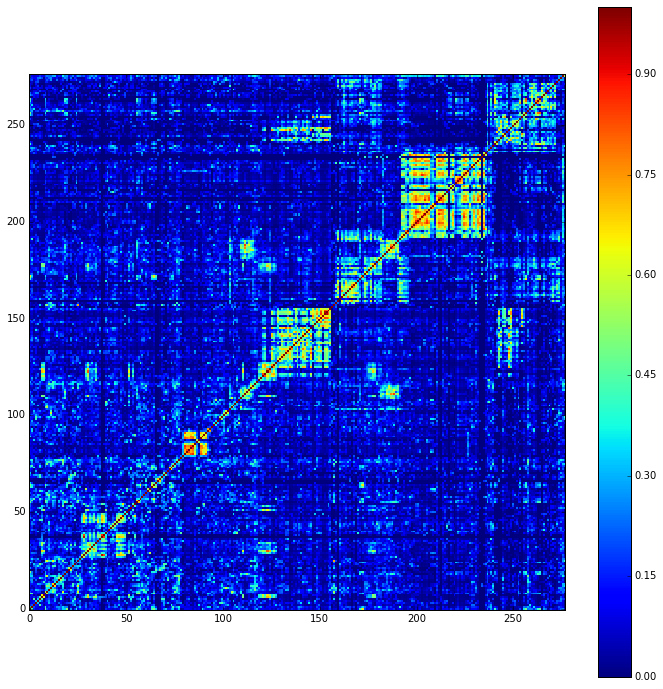

In [22]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.imshow(cos_sim, origin='lower', interpolation='nearest')
plt.colorbar()

In [23]:
cos_dist = cosine_distances(matrix)
euc_dist = euclidean_distances(matrix)

k = len(chps)
km = KMeans(k,
            init='random',
            #init='k-means++', 
            n_init=100, 
            max_iter=1000, 
            tol=1e-7, 
            precompute_distances=True, 
            verbose=0, 
            random_state=1, 
            copy_x=True,
            n_jobs=4
            )

assignments = km.fit_predict(cos_dist)
print np.unique(assignments)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [24]:
df['cluster_chaps'] = assignments + 1

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score

Homogeneity metric of a cluster labeling given a ground truth
A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [25]:
metrics.homogeneity_score(df.chap, df.cluster_chaps)

0.52612161259541113

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score

Completeness metric of a cluster labeling given a ground truth
A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [26]:
metrics.completeness_score(df.chap, df.cluster_chaps)

0.55857161706027691

chap
1     [[Axes(0.125,0.125;0.775x0.775)]]
2     [[Axes(0.125,0.125;0.775x0.775)]]
3     [[Axes(0.125,0.125;0.775x0.775)]]
4     [[Axes(0.125,0.125;0.775x0.775)]]
5     [[Axes(0.125,0.125;0.775x0.775)]]
6     [[Axes(0.125,0.125;0.775x0.775)]]
7     [[Axes(0.125,0.125;0.775x0.775)]]
8     [[Axes(0.125,0.125;0.775x0.775)]]
9     [[Axes(0.125,0.125;0.775x0.775)]]
10    [[Axes(0.125,0.125;0.775x0.775)]]
11    [[Axes(0.125,0.125;0.775x0.775)]]
12    [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

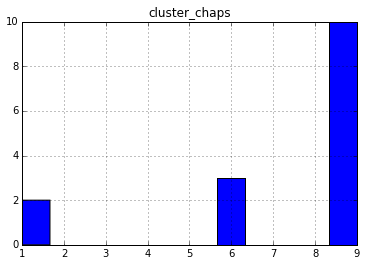

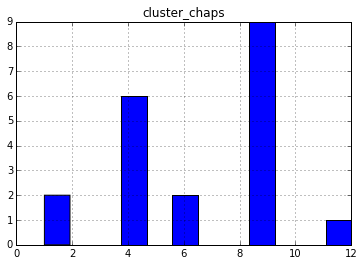

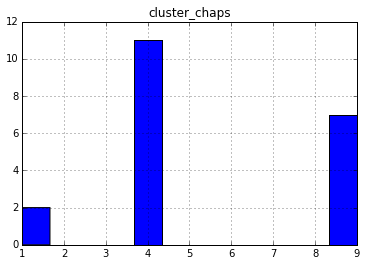

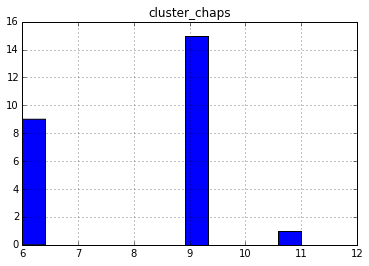

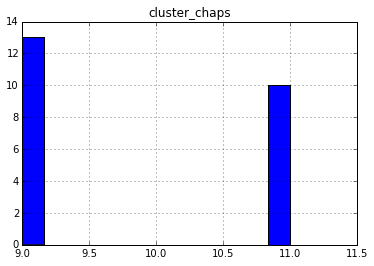

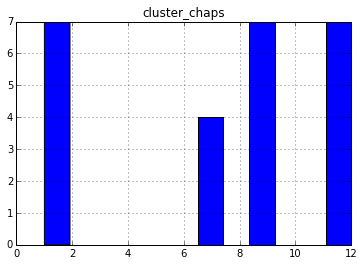

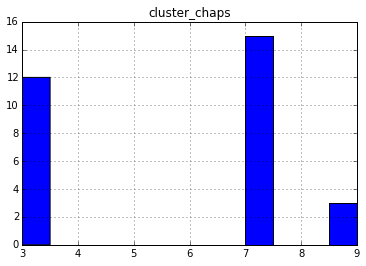

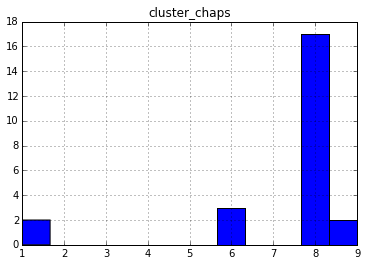

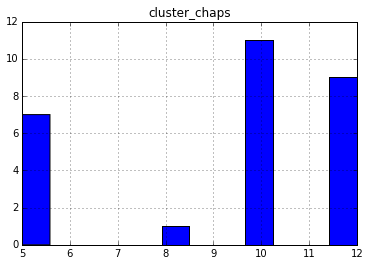

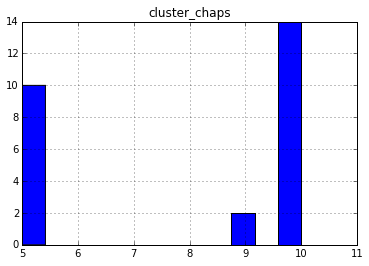

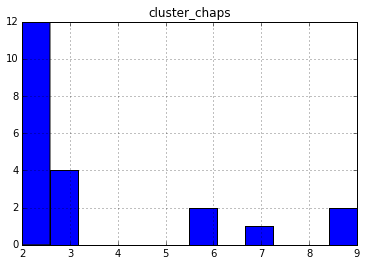

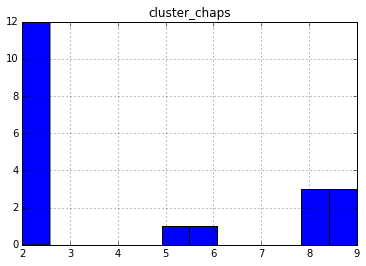

In [27]:
%matplotlib inline
grp = df.groupby('chap')
grp.hist(bins=k)

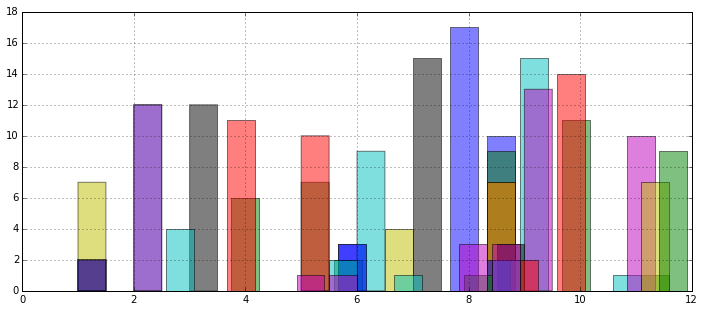

In [28]:
for i in range(1, k+1):
    df[df.chap == i]['cluster_chaps'].hist(figsize=(12,5), alpha=0.5, width=0.5, bins=k)

In [152]:
from sklearn.cross_validation import train_test_split
X = cos_dist
y = df.chap

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
y = np.ravel(y)

In [192]:
print X_train.shape, X_test.shape
print cos_dist.shape

(193, 277) (84, 277)
(277, 277)


In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

clf = RandomForestClassifier(n_estimators=12, 
                             criterion='gini', 
                             max_depth=8, 
                             random_state=1
                            )
                            
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print "Accuracy:", metrics.accuracy_score(y_test, y_pred)

Accuracy: 0.559523809524


In [155]:
# borrowed from Deepthi, Kaggle Introduction presenter
def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y_test, y_pred)
    #array = np.zeros(cm.shape, dtype=np.int16)
    #cm = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    #cm.columns.name = 'Predicted label'
    #cm.index.name = 'True label'
    error_rate = (y_pred != y_test).mean()
    
    return cm

(12, 12)


<matplotlib.colorbar.Colorbar instance at 0x7ff47f4ab368>

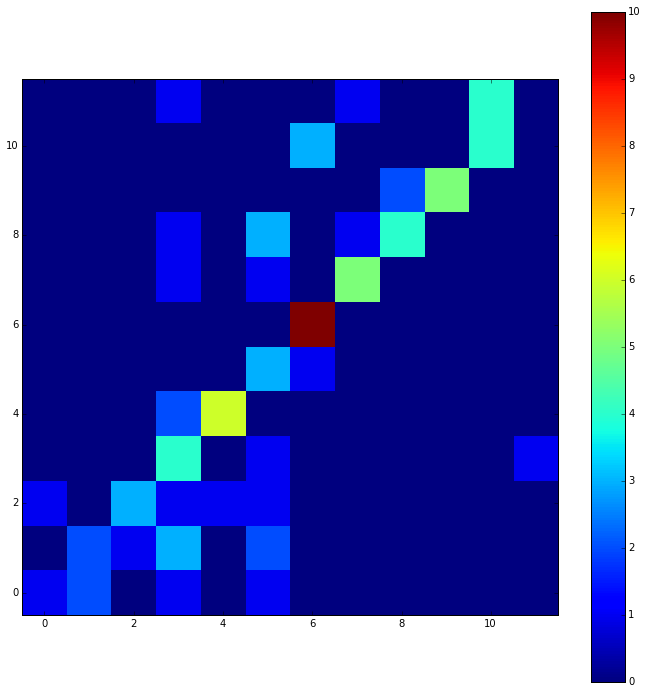

In [185]:
cm = confusion_matrix(y_test, y_pred)
print cm.shape
plt.figure(figsize=(12, 12))
plt.imshow(cm, origin='lower', interpolation='nearest')
plt.colorbar()

In [215]:
importances = clf.feature_importances_
print "Num of import vectors:", importances.size
indices = np.argsort(importances)[0:15]

inverse_features = vectorizer.inverse_transform(matrix)
print "Num of feature vectors", len(inverse_features)

Num of import vectors: 277
Num of feature vectors 277


In [216]:
for i in range(indices.size):
    string = "Rank:%(rank)i -- %(features)s"
    words = ", ".join(inverse_features[indices[i]])
    string = string %{"rank":i,
                     "features":words
                     }
    print string
#fea_name = np.array(features)[indices]
#fea_names = np.array(features)[indices]

Rank:0 -- child, littl, eye, day
Rank:1 -- caterpillar, mouth, arm, someth, minut, size, littl, thing, noth, alic
Rank:2 -- queen, turn, minut, thought, curiou, great, cat, air, head, peopl, time, way, alic
Rank:3 -- queen, mouth, till, tone, game, come, minut, sight, cat, head, idea, thing, end, eye, use, alic
Rank:4 -- king, look, great, hand, cat, head, alic
Rank:5 -- duchess, game, round, right, oh, way, alic
Rank:6 -- someth, larg, great, round, question, ve, right, thing, let, anyth, alic
Rank:7 -- mouth, till, tone, game, size, thought, hurri, half, great, round, long, bit, littl, air, head, right, good, moment, foot, time, dear, oh, way, eye, alic
Rank:8 -- tree, tone, size, thought, look, hurri, larg, poor alic, poor, garden, great, round, head, idea, right, thing, moment, time, way, eye, alic
Rank:9 -- cours, everyth, duchess, larg, thing, way, alic
Rank:10 -- silenc, minut, face, littl, ll, moment, alic, rabbit
Rank:11 -- tone, everyth, talk, duchess, oh, noth, alic
Rank:12 